In [ ]:
!git clone https://github.com/hisfog/SfMNeXt-Impl.git
%cd /content/SfMNeXt-Impl

!pip install absl-py==1.2.0 addict==2.4.0 albumentations==0.5.2 backcall==0.2.0 cachetools==5.2.0 certifi==2022.6.15 charset-normalizer==2.1.0 click==8.1.3 cycler==0.11.0 decorator==5.1.1 docker-pycreds==0.4.0 fonttools==4.33.3 gitdb==4.0.9 GitPython==3.1.27 google-auth==2.11.1 google-auth-oauthlib==0.4.6 grpcio==1.49.0 idna==3.3 imageio==2.19.2 imgaug==0.4.0 importlib-metadata==4.12.0 ipython==7.34.0 jedi==0.18.1 joblib==1.1.0 kiwisolver==1.4.2 lietorch==0.4 Markdown==3.4.1 MarkupSafe==2.1.1 matplotlib==3.4.3 matplotlib-inline==0.1.6 mmcv==1.6.1 networkx==2.6.3 numpy oauthlib==3.2.1 opencv-python==4.6.0.66 opencv-python-headless==4.6.0.66 packaging==21.3 parso==0.8.3 pathtools==0.1.2 pexpect==4.8.0 pickleshare==0.7.5 Pillow==9.1.1 promise==2.3 prompt-toolkit==3.0.31 protobuf==3.19.5 psutil==5.9.1 ptyprocess==0.7.0 pyasn1==0.4.8 pyasn1-modules==0.2.8 Pygments==2.13.0 pyparsing==3.0.9 python-dateutil==2.8.2 PyWavelets==1.3.0 PyYAML==6.0 qudida==0.0.4 requests==2.28.1 requests-oauthlib==1.3.1 rsa==4.9 scikit-image==0.19.2 scikit-learn==1.0.2 scipy==1.7.3 sentry-sdk==1.6.0 setproctitle==1.2.3 Shapely==1.8.4 shortuuid==1.0.9 six==1.16.0 smmap==5.0.0 tdqm==0.0.1 tensorboard==2.10.0 tensorboard-data-server==0.6.1 tensorboard-plugin-wit==1.8.1 tensorboardX==2.5 threadpoolctl==3.1.0 tifffile==2021.11.2 timm==0.6.7 torch torchvision tqdm==4.64.0 traitlets==5.4.0 typing-extensions==4.2.0 urllib3==1.26.10 wandb==0.12.21 wcwidth==0.2.5 Werkzeug==2.2.2 yacs==0.1.8 yapf==0.32.0 zipp==3.8.0

from IPython.display import clear_output
clear_output()
# remember to restart session!

In [ ]:
%cd /content/SfMNeXt-Impl

import argparse
import os
import sys

import numpy as np
import torch
import PIL.Image as pil
import torch.nn as nn
from PIL import Image
from tqdm import tqdm

# import model_io
from SQLdepth import SQLdepth, MonodepthOptions
# from options import MonodepthOptions
from torchvision.transforms import ToPILImage


def denormalize(x, device='cpu'):
    mean = torch.Tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to(device)
    std = torch.Tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(device)
    return x * std + mean

def predict_tta(model, image, args, device, original_width, original_height):
    pred = model(image)
    # pred = model(image)["disp", 0]
    # pred = np.clip(pred.cpu().numpy(), args.min_depth, args.max_depth)
    pred = pred.cpu().numpy()

    image = torch.Tensor(np.array(image.cpu().numpy())[..., ::-1].copy()).to(device)

    pred_lr = model(image)
    # pred_lr = model(image)["disp", 0]
    # pred_lr = np.clip(pred_lr.cpu().numpy()[..., ::-1], args.min_depth, args.max_depth)
    pred_lr = pred_lr.cpu().numpy()[..., ::-1]
    final = 0.5 * (pred + pred_lr)
    # final = pred
    final = nn.functional.interpolate(torch.Tensor(final), (original_height, original_width), mode='bilinear', align_corners=True)
    return torch.Tensor(final)


def eval(model, image, args, original_width, original_height, gpus=None):
    if gpus is None:
        device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    else:
        device = gpus[0]

    if args.save_dir is not None:
        if not os.path.exists(args.save_dir):
            os.makedirs(args.save_dir)

    # crop_size = (471 - 45, 601 - 41)
    # bins = utils.get_bins(100)
    total_invalid = 0
    with torch.no_grad():
        image = image.to(device)
        final = predict_tta(model, image, args, device, original_width, original_height)
        final = final.squeeze().cpu().numpy()

        # final[final < args.min_depth] = args.min_depth
        # final[final > args.max_depth] = args.max_depth
        final[np.isinf(final)] = args.max_depth
        final[np.isnan(final)] = args.min_depth

        # if args.save_dir is not None:
        #     if args.dataset == 'nyu':
        #         impath = f"{batch['image_path'][0].replace('/', '__').replace('.jpg', '')}"
        #         factor = 1000
        #     else:
        #         dpath = batch['image_path'][0].split('/')
        #         impath = dpath[1] + "_" + dpath[-1]
        #         impath = impath.split('.')[0]
        #         factor = 256

            # rgb_dir = "/mnt/bn/hy01/wangyouhong/NYU_test_images/"
            # rgb_path = os.path.join(rgb_dir, f"{impath}.png")
            # ToPILImage()(denormalize(image.squeeze().unsqueeze(0).cpu()).squeeze()).save(rgb_path)

            # pred_path = os.path.join(args.save_dir, f"{impath}.png")
            # pred = (final * factor).astype('uint16')
            # Image.fromarray(pred).save(pred_path)

    return final


def convert_arg_line_to_args(arg_line):
    for arg in arg_line.split():
        if not arg.strip():
            continue
        yield str(arg)

# Arguments
class args:
  n_bins = 256
  gpu = 0
  save = False
  root = "."
  dataset = "nyu"
  data_path = "../dataset/nyu/sync/"
  gt_path = "../dataset/nyu/sync/"
  filenames_file = "./train_test_inputs/nyudepthv2_train_files_with_gt.txt"
  input_height = 416
  input_width = 544
  max_depth = 80
  min_depth = 1e-3
  do_kb_crop = False
  data_path_eval = "../dataset/nyu/official_splits/test/"
  gt_path_eval = "../dataset/nyu/official_splits/test/"
  filenames_file_eval = "./train_test_inputs"
  checkpoint_path = ''
  min_depth_eval = 1e-3
  max_depth_eval = 80
  eigen_crop = False
  garg_crop = False
  do_kb_crop = False
  save_dir = None


class opt:
  model_type = "cvnxt_L"
  model_dim = 32
  patch_size = 32
  dim_out = 64
  query_nums = 64
  dec_channels = [1024, 512, 256, 128]
  min_depth = 0.001
  max_depth = 80.0
  load_pretrained_model = True
  load_pt_folder = "/content/drive/MyDrive/Colab Notebooks/depth-estimation/SQLdepth"
  height = 320
  width = 1024
  image_path = ''
  ext = "jpg"
  backbone = 'tf_efficientnet_b5_ap'
  no_cuda = False

distributed = False
model = SQLdepth(opt)
model = model.to(torch.device('cuda'))
# model = model_io.load_checkpoint(args.checkpoint_path, model)[0]
model = model.eval()

from IPython.display import clear_output
clear_output()

In [ ]:
# helper functions
import os

MAX_RANGE = opt.max_depth

outdoor_folder_path = '/content/drive/MyDrive/PW/Praca/DIODE_evaluation/outdoor/*/*/*.png'
indoor_folder_path = '/content/drive/MyDrive/PW/Praca/DIODE_evaluation/indoors/*/*/*.png'
nyu_folder_path = '/content/drive/MyDrive/PW/Praca/NYUv2/rgb/*.jpg'
stray_folder_path = '/content/drive/MyDrive/PW/Praca/stray_dataset/*/first_frame.png'
stray_indoor_folder_path = '/content/drive/MyDrive/PW/Praca/stray_indoor/*/first_frame.png'
kitti_folder_path = '/content/drive/MyDrive/PW/Praca/kitti_evaluation/image/*.png'
vkitti2_folder_path = '/content/drive/MyDrive/PW/Praca/vkitti2_evaluation/vkitti_2.0.3_rgb/*/15-deg-left/frames/rgb/Camera_0/*.jpg'
taskonomy_folder_path = '/content/drive/MyDrive/PW/Praca/Taskonomy/rgb/allensville/*.png'
actual_path = indoor_folder_path

def get_gt_path(image_path):
    if actual_path in [indoor_folder_path, outdoor_folder_path]:
        gt_path = image_path.replace('.png', '_depth.npy')
    elif actual_path in [stray_folder_path, stray_indoor_folder_path]:
        gt_path = image_path.replace('first_frame.png', 'depth/000000.png')
    elif actual_path == nyu_folder_path:
        dir_name, image_name = os.path.split(image_path)
        gt_path = os.path.join(dir_name.replace('rgb', 'depth'), image_name.replace('jpg', 'npy'))
    elif actual_path == vkitti2_folder_path:
        gt_path = image_path.replace('rgb', 'depth').replace('jpg', 'png')
    elif actual_path == kitti_folder_path:
        gt_path = image_path.replace('image', 'groundtruth_depth', 2)
    elif actual_path == taskonomy_folder_path:
        gt_path = image_path.replace('rgb', 'depth_euclidean')
    return gt_path

def get_error_mask(gt):
    if actual_path in [indoor_folder_path, outdoor_folder_path]:
        if MAX_RANGE:
            mask = (gt > 0.6) & (gt < MAX_RANGE)
        else:
            mask = (gt > 0.6) & (gt < 350)
    elif actual_path in [stray_folder_path, stray_indoor_folder_path]:
        mask = (gt > 0.3) & (gt < 5)
    elif actual_path == nyu_folder_path:
        mask = (gt > 0) & (gt < 10)
    elif actual_path == vkitti2_folder_path:
        if MAX_RANGE:
            mask = (gt > 2.5) & (gt < MAX_RANGE)
        else:
            mask = (gt > 2.5) & (gt < 85)
    elif actual_path == kitti_folder_path:
        if MAX_RANGE:
            mask = (gt > 0) & (gt < MAX_RANGE)
        else:
            mask = (gt > 0)
    elif actual_path == taskonomy_folder_path:
        if MAX_RANGE:
            mask = (gt > 0) & (gt < MAX_RANGE)
        else:
            mask = (gt > 0) & (gt < 128)
    return mask

def get_depth_gt(gt_path):
    if actual_path in [outdoor_folder_path, indoor_folder_path]:
        depth_gt = np.load(gt_path).squeeze()
    elif actual_path == nyu_folder_path:
        depth_gt = np.load(gt_path)
    elif actual_path in [stray_folder_path, stray_indoor_folder_path]:
        depth_gt = cv2.imread(gt_path, -1) / 1000
    elif actual_path == vkitti2_folder_path:
        depth_gt = cv2.imread(gt_path, cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH) / 100
    elif actual_path == kitti_folder_path:
        depth_gt = cv2.imread(gt_path, 0)
    elif actual_path == taskonomy_folder_path:
        depth_gt = cv2.imread(gt_path, -1) / 512
    return depth_gt

def compute_errors(gt, pred):
    mask = get_error_mask(gt)
    gt = gt[mask]
    pred = pred[mask]

    thresh = np.maximum((gt / pred), (pred / gt))
    a1 = (thresh < 1.25).mean()
    a2 = (thresh < 1.25 ** 2).mean()
    a3 = (thresh < 1.25 ** 3).mean()

    abs_rel = np.mean((np.abs(gt - pred) / gt))
    sq_rel = np.mean((((gt - pred) ** 2) / gt))

    rmse = (gt - pred) ** 2
    rmse = np.sqrt(rmse.mean())

    rmse_log = (np.log(gt) - np.log(pred)) ** 2
    rmse_log = np.sqrt(rmse_log.mean())

    err = (np.log(pred) - np.log(gt))
    silog = np.sqrt(np.mean(err ** 2) - np.mean(err) ** 2) * 100

    log_10 = (np.abs(np.log10(gt) - np.log10(pred))).mean()
    return dict(a1=a1, a2=a2, a3=a3, abs_rel=abs_rel, rmse=rmse, log_10=log_10, rmse_log=rmse_log,
                silog=silog, sq_rel=sq_rel)

In [ ]:
import time, glob, cv2
from torchvision import transforms

results = []
images = [i for i in glob.iglob(actual_path, recursive=True)]
for image_path in tqdm(images):
    gt_path = get_gt_path(image_path)
    start_time = time.time()

    input_image = pil.open(image_path).convert('RGB')
    original_width, original_height = input_image.size
    input_image = input_image.resize((opt.width, opt.height), pil.LANCZOS)
    input_image = transforms.ToTensor()(input_image).unsqueeze(0)

    pred_depth = eval(model, input_image, args, original_width, original_height, gpus=[torch.device('cuda')])

    exec_time = (time.time() - start_time)
    if actual_path in [stray_folder_path, stray_indoor_folder_path]:
        pred_depth = cv2.resize(pred_depth, (256, 192))
    results.append({'pred_depth': pred_depth, 'gt_path': gt_path, 'exec_time': exec_time})


  0%|          | 0/10 [00:00<?, ?it/s]<ipython-input-13-6a7bb1f09185>:12: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  input_image = input_image.resize((opt.width, opt.height), pil.LANCZOS)
100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


In [ ]:
import numpy as np
import cv2

# compute errors on results
metrics = []
print("computing errors...")
for result in tqdm(results):
    depth_gt = get_depth_gt(result['gt_path'])
    metrics.append({"exec_time": result['exec_time'], **compute_errors(depth_gt, result['pred_depth'])})

# compute mean values
values_list = {
    "a1": [],
    "a2": [],
    "a3": [],
    "abs_rel": [],
    "rmse": [],
    "log_10": [],
    "rmse_log": [],
    "silog": [],
    "sq_rel": [],
    "exec_time": [],
}
for metric in metrics:
    for key, value in metric.items():
        values_list[key].append(value)

mean_values = {}
for key, value in values_list.items():
    mean_values[key] = sum(value) / len(value)

print('\n', mean_values)

computing errors...


100%|██████████| 19/19 [00:00<00:00, 108.30it/s]


 {'a1': 0.018358222886177916, 'a2': 0.14295469527022348, 'a3': 0.3628120798282383, 'abs_rel': 1.38687169067613, 'rmse': 5.237537991926689, 'log_10': 0.34148859843707674, 'rmse_log': 0.8289481454322116, 'silog': 26.53522929410433, 'sq_rel': 11.349067261075376, 'exec_time': 0.6016622468044883}


In [ ]:
# debug set

num = 6
y, x = (200, 250)

gt_depth = get_depth_gt(results[num]['gt_path'])
pred_depth = results[num]['pred_depth']

print(gt_depth[y][x])
print(pred_depth[y][x])

import matplotlib.pyplot as plt
f = plt.figure()
f.add_subplot(1,2, 1)
plt.imshow(gt_depth)
f.add_subplot(1,2, 2)
plt.imshow(pred_depth)
plt.show(block=True)

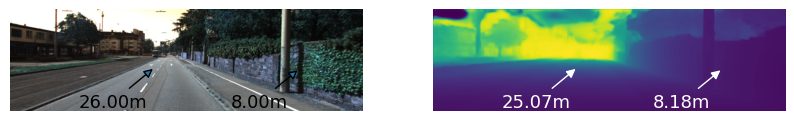

In [ ]:
# KITTI visualisation

num = 4
y, x = (205, 1000)
y2, x2 = (200, 500)

gt_depth = get_depth_gt(results[num]['gt_path'])
pred_depth = results[num]['pred_depth']

rgb_path = results[num]['gt_path'].replace('groundtruth_depth', 'image', 2)

fontsize = 13
xytext1 = (-50, -24)
xytext2 = (-55, -25)

import matplotlib.pyplot as plt
f = plt.figure(figsize=(10, 15))
ax = f.add_subplot(1, 2, 1)
ax.set_axis_off()
ax.annotate("{:.2f}m".format(gt_depth[y][x]), (x, y), xytext=xytext1, textcoords='offset points', arrowprops={'arrowstyle': '-|>'}, fontsize=fontsize, va='center')
ax.annotate("{:.2f}m".format(gt_depth[y2][x2]), (x2, y2), xytext=xytext2, textcoords='offset points', arrowprops={'arrowstyle': '-|>'}, fontsize=fontsize, va='center')

plt.imshow(cv2.imread(rgb_path))
ax = f.add_subplot(1, 2, 2)
ax.set_axis_off()
ax.annotate("{:.2f}m".format(pred_depth[y][x]), (x, y), xytext=xytext1, textcoords='offset points', arrowprops={'arrowstyle': '-|>', 'color': 'white'}, fontsize=fontsize, color='white', va='center')
ax.annotate("{:.2f}m".format(pred_depth[y2][x2]), (x2, y2), xytext=xytext2, textcoords='offset points', arrowprops={'arrowstyle': '-|>', 'color': 'white'}, fontsize=fontsize, color='white', va='center')

plt.imshow(pred_depth)
plt.show(block=True)

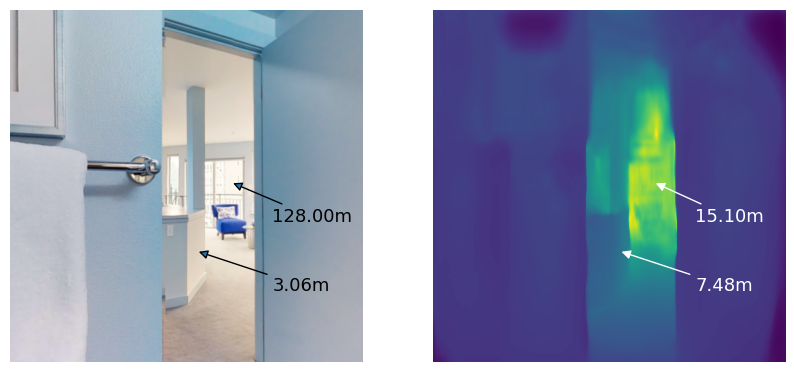

In [ ]:
# Taskonomy visualisation

num = 9
y, x = (250, 320)
y2, x2 = (350, 270)

gt_depth = get_depth_gt(results[num]['gt_path'])
pred_depth = results[num]['pred_depth']

rgb_path = results[num]['gt_path'].replace('depth_euclidean', 'rgb')

fontsize = 13
xytext1 = (30, -25)
xytext2 = (55, -25)

import matplotlib.pyplot as plt
f = plt.figure(figsize=(10, 15))
ax = f.add_subplot(1, 2, 1)
ax.set_axis_off()
ax.annotate("{:.2f}m".format(gt_depth[y][x]), (x, y), xytext=xytext1, textcoords='offset points', arrowprops={'arrowstyle': '-|>'}, fontsize=fontsize, va='center')
ax.annotate("{:.2f}m".format(gt_depth[y2][x2]), (x2, y2), xytext=xytext2, textcoords='offset points', arrowprops={'arrowstyle': '-|>'}, fontsize=fontsize, va='center')

plt.imshow(cv2.imread(rgb_path))
ax = f.add_subplot(1, 2, 2)
ax.set_axis_off()
ax.annotate("{:.2f}m".format(pred_depth[y][x]), (x, y), xytext=xytext1, textcoords='offset points', arrowprops={'arrowstyle': '-|>', 'color': 'white'}, fontsize=fontsize, color='white', va='center')
ax.annotate("{:.2f}m".format(pred_depth[y2][x2]), (x2, y2), xytext=xytext2, textcoords='offset points', arrowprops={'arrowstyle': '-|>', 'color': 'white'}, fontsize=fontsize, color='white', va='center')

plt.imshow(pred_depth)
plt.show(block=True)

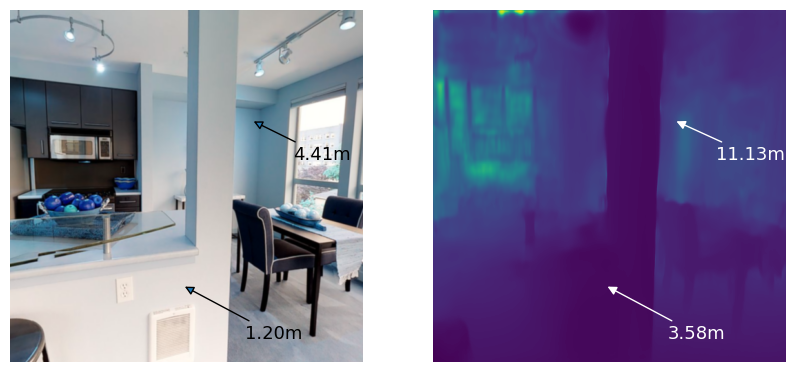

In [ ]:
# Taskonomy visualisation

num = 3
y, x = (160, 350)
y2, x2 = (400, 250)

gt_depth = get_depth_gt(results[num]['gt_path'])
pred_depth = results[num]['pred_depth']

rgb_path = results[num]['gt_path'].replace('depth_euclidean', 'rgb')

fontsize = 13
xytext1 = (30, -25)
xytext2 = (45, -35)

import matplotlib.pyplot as plt
f = plt.figure(figsize=(10, 15))
ax = f.add_subplot(1, 2, 1)
ax.set_axis_off()
ax.annotate("{:.2f}m".format(gt_depth[y][x]), (x, y), xytext=xytext1, textcoords='offset points', arrowprops={'arrowstyle': '-|>'}, fontsize=fontsize, va='center')
ax.annotate("{:.2f}m".format(gt_depth[y2][x2]), (x2, y2), xytext=xytext2, textcoords='offset points', arrowprops={'arrowstyle': '-|>'}, fontsize=fontsize, va='center')

plt.imshow(cv2.imread(rgb_path))
ax = f.add_subplot(1, 2, 2)
ax.set_axis_off()
ax.annotate("{:.2f}m".format(pred_depth[y][x]), (x, y), xytext=xytext1, textcoords='offset points', arrowprops={'arrowstyle': '-|>', 'color': 'white'}, fontsize=fontsize, color='white', va='center')
ax.annotate("{:.2f}m".format(pred_depth[y2][x2]), (x2, y2), xytext=xytext2, textcoords='offset points', arrowprops={'arrowstyle': '-|>', 'color': 'white'}, fontsize=fontsize, color='white', va='center')

plt.imshow(pred_depth)
plt.show(block=True)

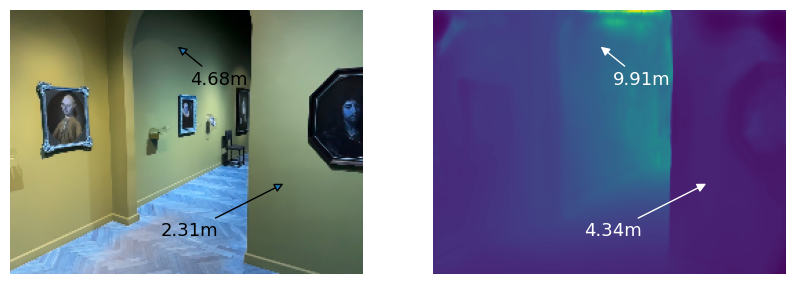

In [ ]:
# Stray indoor visualisation

num = 7
y, x = (25, 120)
y2, x2 = (125, 200)

gt_depth = get_depth_gt(results[num]['gt_path'])
pred_depth = results[num]['pred_depth']

rgb_path = results[num]['gt_path'].replace('depth/000000.png', 'first_frame.png')

fontsize = 13
xytext1 = (10, -25)
xytext2 = (-90, -35)

import matplotlib.pyplot as plt
f = plt.figure(figsize=(10, 15))
ax = f.add_subplot(1, 2, 1)
ax.set_axis_off()
ax.annotate("{:.2f}m".format(gt_depth[y][x]), (x, y), xytext=xytext1, textcoords='offset points', arrowprops={'arrowstyle': '-|>'}, fontsize=fontsize, va='center')
ax.annotate("{:.2f}m".format(gt_depth[y2][x2]), (x2, y2), xytext=xytext2, textcoords='offset points', arrowprops={'arrowstyle': '-|>'}, fontsize=fontsize, va='center')

plt.imshow(cv2.resize(cv2.imread(rgb_path), (256, 192)))
ax = f.add_subplot(1, 2, 2)
ax.set_axis_off()
ax.annotate("{:.2f}m".format(pred_depth[y][x]), (x, y), xytext=xytext1, textcoords='offset points', arrowprops={'arrowstyle': '-|>', 'color': 'white'}, fontsize=fontsize, color='white', va='center')
ax.annotate("{:.2f}m".format(pred_depth[y2][x2]), (x2, y2), xytext=xytext2, textcoords='offset points', arrowprops={'arrowstyle': '-|>', 'color': 'white'}, fontsize=fontsize, color='white', va='center')

plt.imshow(pred_depth)
plt.show(block=True)

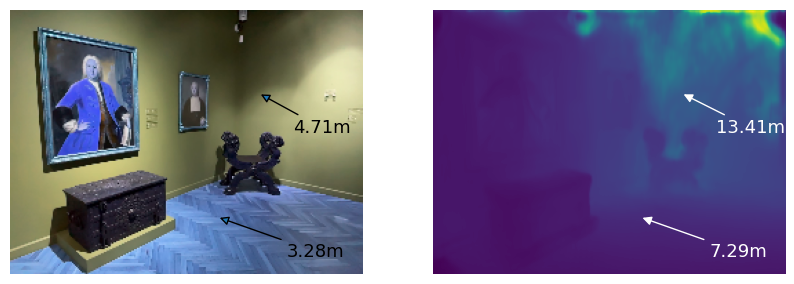

In [ ]:
# Stray indoor visualisation

num = 9
y, x = (60, 180)
y2, x2 = (150, 150)

gt_depth = get_depth_gt(results[num]['gt_path'])
pred_depth = results[num]['pred_depth']

rgb_path = results[num]['gt_path'].replace('depth/000000.png', 'first_frame.png')

fontsize = 13
xytext1 = (25, -25)
xytext2 = (50, -25)

import matplotlib.pyplot as plt
f = plt.figure(figsize=(10, 15))
ax = f.add_subplot(1, 2, 1)
ax.set_axis_off()
ax.annotate("{:.2f}m".format(gt_depth[y][x]), (x, y), xytext=xytext1, textcoords='offset points', arrowprops={'arrowstyle': '-|>'}, fontsize=fontsize, va='center')
ax.annotate("{:.2f}m".format(gt_depth[y2][x2]), (x2, y2), xytext=xytext2, textcoords='offset points', arrowprops={'arrowstyle': '-|>'}, fontsize=fontsize, va='center')

plt.imshow(cv2.resize(cv2.imread(rgb_path), (256, 192)))
ax = f.add_subplot(1, 2, 2)
ax.set_axis_off()
ax.annotate("{:.2f}m".format(pred_depth[y][x]), (x, y), xytext=xytext1, textcoords='offset points', arrowprops={'arrowstyle': '-|>', 'color': 'white'}, fontsize=fontsize, color='white', va='center')
ax.annotate("{:.2f}m".format(pred_depth[y2][x2]), (x2, y2), xytext=xytext2, textcoords='offset points', arrowprops={'arrowstyle': '-|>', 'color': 'white'}, fontsize=fontsize, color='white', va='center')

plt.imshow(pred_depth)
plt.show(block=True)

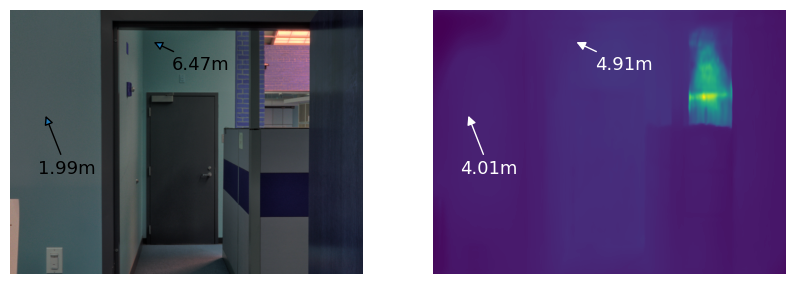

In [ ]:
# DIODE indoor visualisation

num = 1
y, x = (300, 100)
y2, x2 = (90, 410)

gt_depth = get_depth_gt(results[num]['gt_path'])
pred_depth = results[num]['pred_depth']

rgb_path = results[num]['gt_path'].replace('_depth.npy', '.png')

fontsize = 13
xytext1 = (-5, -40)
xytext2 = (15, -17)

import matplotlib.pyplot as plt
f = plt.figure(figsize=(10, 15))
ax = f.add_subplot(1, 2, 1)
ax.set_axis_off()
ax.annotate("{:.2f}m".format(gt_depth[y][x]), (x, y), xytext=xytext1, textcoords='offset points', arrowprops={'arrowstyle': '-|>'}, fontsize=fontsize, va='center')
ax.annotate("{:.2f}m".format(gt_depth[y2][x2]), (x2, y2), xytext=xytext2, textcoords='offset points', arrowprops={'arrowstyle': '-|>'}, fontsize=fontsize, va='center')

plt.imshow(cv2.imread(rgb_path))
ax = f.add_subplot(1, 2, 2)
ax.set_axis_off()
ax.annotate("{:.2f}m".format(pred_depth[y][x]), (x, y), xytext=xytext1, textcoords='offset points', arrowprops={'arrowstyle': '-|>', 'color': 'white'}, fontsize=fontsize, color='white', va='center')
ax.annotate("{:.2f}m".format(pred_depth[y2][x2]), (x2, y2), xytext=xytext2, textcoords='offset points', arrowprops={'arrowstyle': '-|>', 'color': 'white'}, fontsize=fontsize, color='white', va='center')

plt.imshow(pred_depth)
plt.show(block=True)